Group Name: Team Flash

Students:
- Mohamed Radwan
- Mithunan Sivegnanam

In [88]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dat300-h2020-ca2/train.h5
/kaggle/input/dat300-h2020-ca2/sample_submission.csv
/kaggle/input/dat300-h2020-ca2/test.h5


In [90]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [91]:
import h5py

with h5py.File('/kaggle/input/dat300-h2020-ca2/train.h5', 'r') as hf:
    print(list(hf.keys()))
    X_ = hf['X'][:]
    y_ = hf['y'][:]
with h5py.File('/kaggle/input/dat300-h2020-ca2/test.h5', 'r') as hf:
    X_test = hf['X'][:]

['X', 'y']


## Checking Balance of the mask colors

In [72]:
unique_elements, counts_elements = np.unique(y_, return_counts=True)
print("Frequency of unique values in y:")
print(unique_elements)
print(counts_elements)
# cheack for class balance
print(counts_elements[0]/(counts_elements[1]+counts_elements[0]))
print(counts_elements[1]/(counts_elements[1]+counts_elements[0]))

Frequency of unique values in y:
[  0. 255.]
[24904280 24247720]
0.5066788736979166
0.49332112630208336


In [92]:
SEED = 42
tf.compat.v1.set_random_seed(SEED)

## Normalizing the data

In [93]:
X = X_.astype('float32')
y = y_.astype('float32')
X_test = X_test.astype('float32')

mean = np.mean(X_)  # mean for data centering
std = np.std(X_)  # std for data normalization

X -= mean
X /= std

X_test -= mean
X_test /= std

y /= 255.  # scale masks to [0, 1]

## Visualizatiuon of some random data

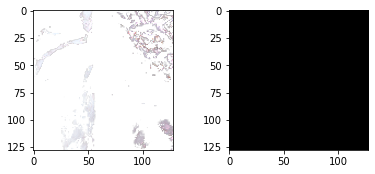

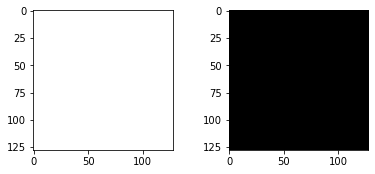

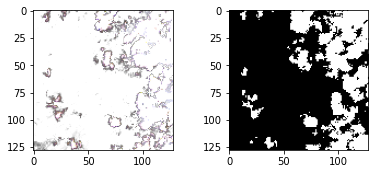

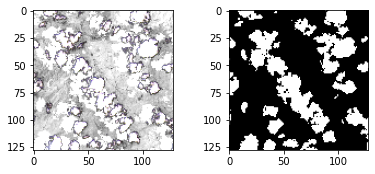

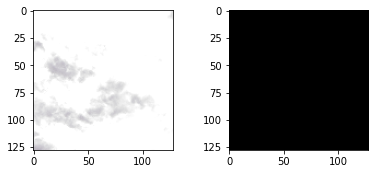

In [75]:
import matplotlib.pyplot as plt
for i in range(20, 70, 10):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(X[i])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(y[i], (128, 128)), cmap="gray")

It's noticed that some of the data doesn't contain masks (Black masks), But when we remove the those data points + masks. The Network will tends to increase the fractions of false positives. 

In [54]:
X.shape, y.shape

((3000, 128, 128, 4), (3000, 128, 128, 1))

In [94]:
 """
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 1, kernel_size=3):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = kernel_size, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## The used losses

In [95]:
batch_size = 128
input_img = Input(shape=(128,128, 4))

def jacc_coef(y_true, y_pred):
    smooth = 0.00001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice_coef_sample = (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)
    return dice_coef_sample

def bce_dice_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

def fbeta_loss(y_true, y_pred):
    return 1-fbeta(y_true, y_pred)

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.1,
                                                 patience=10,
                                                 min_lr=0.000001)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_dice_coef')>=0.985) and (logs.get('dice_coef')>=0.985):
            print('accuracy reached')
            self.model.stop_training = True
accuracy_reached = myCallback()

We used all those losses
- Binary cross entropy
- Dice
- Jaccard Distance
- Binary cross entropy + Dice
- fbeta

But the final model here is based only on Dice loss

### Optimizing Learning rate

Using LR scedualer and record the learning rate vs the loss or the metrics

## Adding Dropout

To reduce any possible overfitting

In [ ]:
with tpu_strategy.scope():
    model = get_unet(input_img, n_filters = 64, dropout = 0.3, batchnorm = True, n_classes = 1)
    model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(), metrics=[dice_coef])
history = model.fit(X, y, batch_size=batch_size, epochs=50, shuffle=True, validation_split=0.2, callbacks=[lr_schedule]) 

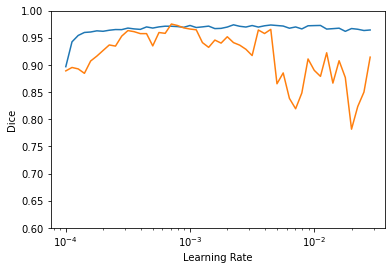

In [82]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["dice_coef"])
plt.semilogx(history.history["lr"], history.history["val_dice_coef"])
plt.xlabel('Learning Rate')
plt.ylabel('Dice')
plt.ylim(0.6, 1)
plt.show()

Optimal learning rate given the dice score is 6e-4 

In [ ]:
with tpu_strategy.scope():
    model = get_unet(input_img, n_filters = 64, dropout = 0.3, batchnorm = True, n_classes = 1)
    model.compile(loss=bce_dice_loss, optimizer=tf.keras.optimizers.Adam(8e-4), metrics=[dice_coef])
history = model.fit(X, y, batch_size=batch_size, epochs=200, shuffle=True, validation_split=0.2, callbacks=[accuracy_reached]) 

## Training vs Validation curve

<Figure size 432x288 with 0 Axes>

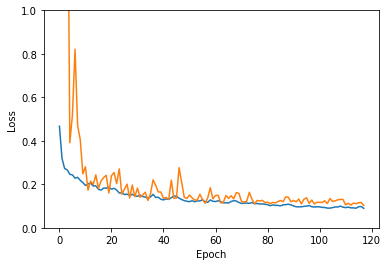

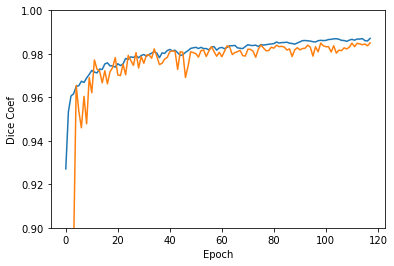

<Figure size 432x288 with 0 Axes>

In [84]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
dice_coef = history.history["dice_coef"]
val_dice_coef = history.history["val_dice_coef"]
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.figure()

plt.plot(epochs, dice_coef)
plt.plot(epochs, val_dice_coef)
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.ylim(0.9, 1)
plt.figure()

In [ ]:
with tpu_strategy.scope():
    final_model = get_unet(input_img, n_filters = 64, dropout = 0.3, batchnorm = True, n_classes = 1)
    final_model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(8e-4), metrics=[dice_coef])
history = final_model.fit(X, y, batch_size=batch_size, epochs=120, shuffle=True) 

This final model achieved 0.95507 on kaggle

## Stack ensembles

This is intensive process, will take more than 1 hour on TPUs. And it get accuracies around 96%

In [ ]:
def stack_all_models():
    X_stacks = None
    y_stacks = None

    all_models = []
    num_filters = [8, 16, 32, 64, 96, 128]
    for i in num_filters:
        with tpu_strategy.scope():
            model = get_unet(input_img, n_filters = i, dropout = 0.0, batchnorm = True, n_classes = 1)
            model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.RMSprop(3e-4), metrics=[dice_coef])
            print('Model '+str(i)+ ' Started')
        model.fit(X, y, batch_size=batch_size, epochs=300, shuffle=True, verbose=0) 
        # train all models on original train data
        all_models.append(model)

    for model in all_models:
        pred = model.predict(X_test)
        if X_stacks is None:
            X_stacks = X_test
            y_stacks = pred
        else:
            y_stacks = np.vstack((y_stacks, pred)) 
            X_stacks = np.vstack((X_stacks, X_test))  

    with tpu_strategy.scope():
        meta_model = get_unet(input_img, n_filters = 32, dropout = 0.0, batchnorm = True, n_classes = 1)
        meta_model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.RMSprop(3e-4), metrics=[dice_coef])
    meta_model.fit(X_stacks, y_stacks, epochs=300, batch_size=batch_size, verbose=1)
    all_models.append(meta_model)

    return all_models

all_models = stack_all_models()

## Submission

In [97]:
y_hat = final_model.predict(X_test)
assert y_hat.shape == (500, 128, 128, 1)
y_hat_flatten = np.round(y_hat.flatten()).astype(bool)
submission = pd.DataFrame({'Predicted': y_hat_flatten})
submission.index.name = 'Id'
submission.to_csv("submission.csv",index=True)

## References:

https://gist.github.com/wassname/74f02bc9134897e3fe4e60784f5aaa15

https://github.com/mdbloice/Augmentor

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

https://github.com/jocicmarko/ultrasound-nerve-segmentation

https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

https://www.kaggle.com/cdeotte/keras-unet-with-eda